# Исследование тарифов компании "Мегалайн"

## Цель исследования

Сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.

## Задача исследования

Проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание тарифов

**Тариф «Смарт»**

1.   Ежемесячная плата: 550 рублей
2.   Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3.   Стоимость услуг сверх тарифного пакета:
* минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.)
* сообщение: 3 рубля
* 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
* минута разговора: 1 рубль
* сообщение: 1 рубль
* 1 Гб интернет-трафика: 150 рублей

## Описание данных

Таблица `users` (информация о пользователях):
* *user_id* — уникальный идентификатор пользователя
* *first_name* — имя пользователя
* *last_name* — фамилия пользователя
* *age* — возраст пользователя (годы)
* *reg_date* — дата подключения тарифа (день, месяц, год)
* *churn_date* — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* *city* — город проживания пользователя
* *tariff* — название тарифного плана

Таблица `calls` (информация о звонках):
* *id* — уникальный номер звонка
* *call_date* — дата звонка
* *duration* — длительность звонка в минутах
* *user_id* — идентификатор пользователя, сделавшего звонок

Таблица `messages` (информация о сообщениях):
* *id* — уникальный номер сообщения
* *message_date* — дата сообщения
* *user_id* — идентификатор пользователя, отправившего сообщение

Таблица `internet` (информация об интернет-сессиях):
* *id* — уникальный номер сессии
* *mb_used* — объём потраченного за сессию интернет-трафика (в мегабайтах)
* *session_date* — дата интернет-сессии
* *user_id* — идентификатор пользователя

Таблица `tariffs` (информация о тарифах):
* *tariff_name* — название тарифа
* *rub_monthly_fee* — ежемесячная абонентская плата в рублях
* *minutes_included* — количество минут разговора в месяц, включённых в абонентскую плату
* *messages_included* — количество сообщений в месяц, включённых в абонентскую плату
* *mb_per_month_included* — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* *rub_per_minute* — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* *rub_per_message* — стоимость отправки сообщения сверх тарифного пакета
* *rub_per_gb* — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [1]:
# !pip install seaborn -U

### requirements.txt

In [2]:
# pandas==1.1.5
# pandas-datareader==0.9.0
# pandas-gbq==0.13.3
# pandas-profiling==1.4.1
# numpy==1.19.5
# seaborn==0.11.1
# matplotlib==3.2.2
# tqdm==4.41.1
# scipy==1.4.1

## 1. Изучение общей информации

### Импорт библиотек

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
import math as mt
import requests
from tqdm.notebook import tqdm
from scipy import stats as st

sns.set_theme(style="darkgrid")
# sns.set_palette("Greys_r")
warnings.simplefilter('ignore')
tqdm.pandas()

### Добавление функций

In [4]:
# вывод количества пропущенных значений и процентное соотношение ко всем строкам dataframe
def view_null_values(data):
    return (data
         .isnull()
         .sum()
         .to_frame(name = 'count_null_values')
         .query('count_null_values != 0')
         .assign(percent = lambda x: (x['count_null_values']/len(data)))
         .sort_values(by = 'count_null_values', ascending = False)
         .style.format({'percent' : '{:.1%}'})
    )

In [5]:
# подсчет занимаемой памяти
def mem_usage(data, size = True):
    # проверим, что передаем DataFrame
    if isinstance(data, pd.DataFrame):
        usage_b = data.memory_usage(deep=True).sum()
    # иначе это Series
    else:
        usage_b = data.memory_usage(deep=True)
    # переведем в Мб
    usage_mb = usage_b / 1024 ** 2
    if size: 
        return f"{usage_mb:03.2f} MB"
    return float(f"{usage_mb:03.2f}")

In [6]:
# подсчет количества вариантов
def nCr(n, k):
    return mt.factorial(n) / (mt.factorial(k) * mt.factorial(n-k))

In [7]:
# отрисовка распределения вероятности на графике
def view_p_bar(n, p):
    distr = []

    for k in tqdm(range(0, n + 1)):
        choose = nCr(n, k)
        prob = choose * p ** k * (1 - p) ** (n - k)
        distr.append(prob)

    plt.bar(range(0,n+1), distr)
    plt.xlabel('n', fontweight='bold')
    plt.ylabel('p', fontweight='bold')
    plt.title('p(n)', fontweight='bold')

In [8]:
# проверка гипотез о равенстве среднего двух генеральных совокупностей по взятым из них выборкам
def check_hip(data1, data2, alpha, equal_var = True):
    results = st.ttest_ind(data1, data2, equal_var=equal_var)

    print('p-значение:', results.pvalue)

    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

In [9]:
# проверка равенства дисперсий
def equal_variance(data):
    return np.var(data, ddof=1)

### Обзор данных

In [10]:
data = ['calls.csv', 'internet.csv', 'messages.csv', 'tariffs.csv', 'users.csv']
path = open('link.txt', 'r').readline()

for file in data:
    try:
        response = requests.get(path + file)
        response.raise_for_status()
    except requests.exceptions.HTTPError:
        path = '/datasets/'

calls = pd.read_csv(path + data[0])
internet = pd.read_csv(path + data[1])
messages = pd.read_csv(path + data[2])
tariffs = pd.read_csv(path + data[3])
users = pd.read_csv(path + data[4])

Для удобства вывода напишем вспомогательные функции:

In [11]:
def sep_text(text):
    return print(f'''
===============================================================
{text: ^64}
===============================================================
    ''')

In [12]:
def brows_data(data, name):
    data.name = name
    sep_text('DataFrame' + ': ' + name)
    display(data)
    sep_text('Info' + ': ' + name)
    display(data.info())
    sep_text('Describe' + ': ' + name)
    display(data.describe().T)
    sep_text('Dtypes' + ': ' + name)
    display(data.dtypes)

Выведем краткую информацию о данных:

In [13]:
df_dict = {'calls':calls, 'internet':internet, 'messages':messages, 'tariffs':tariffs, 'users':users}
for name, df in tqdm(df_dict.items()):
    brows_data(df, name)

  0%|          | 0/5 [00:00<?, ?it/s]


                        DataFrame: calls                        
    


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499



                          Info: calls                           
    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None


                        Describe: calls                         
    


,count,mean,std,min,25%,50%,75%,max
duration,202607.0,6.755887,5.843365,0.0,1.3,6.0,10.7,38.0
user_id,202607.0,1253.940619,144.722751,1000.0,1126.0,1260.0,1379.0,1499.0



                         Dtypes: calls                          
    


id            object
call_date     object
duration     float64
user_id        int64
dtype: object


                      DataFrame: internet                       
    


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499



                         Info: internet                         
    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None


                       Describe: internet                       
    


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,149396.0,74697.500000,43127.054745,0.0,37348.7500,74697.500,112046.2500,149395.00
mb_used,149396.0,370.192426,278.300951,0.0,138.1875,348.015,559.5525,1724.83
user_id,149396.0,1252.099842,144.050823,1000.0,1130.0000,1251.000,1380.0000,1499.00



                        Dtypes: internet                        
    


Unnamed: 0        int64
id               object
mb_used         float64
session_date     object
user_id           int64
dtype: object


                      DataFrame: messages                       
    


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499



                         Info: messages                         
    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None


                       Describe: messages                       
    


,count,mean,std,min,25%,50%,75%,max
user_id,123036.0,1256.98941,143.523967,1000.0,1134.0,1271.0,1381.0,1499.0



                        Dtypes: messages                        
    


id              object
message_date    object
user_id          int64
dtype: object


                       DataFrame: tariffs                       
    


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra



                         Info: tariffs                          
    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None


                       Describe: tariffs                        
    


,count,mean,std,min,25%,50%,75%,max
messages_included,2.0,525.0,671.751442,50.0,287.5,525.0,762.5,1000.0
mb_per_month_included,2.0,23040.0,10861.160159,15360.0,19200.0,23040.0,26880.0,30720.0
minutes_included,2.0,1750.0,1767.766953,500.0,1125.0,1750.0,2375.0,3000.0
rub_monthly_fee,2.0,1250.0,989.949494,550.0,900.0,1250.0,1600.0,1950.0
rub_per_gb,2.0,175.0,35.355339,150.0,162.5,175.0,187.5,200.0
rub_per_message,2.0,2.0,1.414214,1.0,1.5,2.0,2.5,3.0
rub_per_minute,2.0,2.0,1.414214,1.0,1.5,2.0,2.5,3.0



                        Dtypes: tariffs                         
    


messages_included         int64
mb_per_month_included     int64
minutes_included          int64
rub_monthly_fee           int64
rub_per_gb                int64
rub_per_message           int64
rub_per_minute            int64
tariff_name              object
dtype: object


                        DataFrame: users                        
    


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart



                          Info: users                           
    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None


                        Describe: users                         
    


,count,mean,std,min,25%,50%,75%,max
user_id,500.0,1249.500,144.481833,1000.0,1124.75,1249.5,1374.25,1499.0
age,500.0,46.588,16.667630,18.0,32.00,46.0,62.00,75.0



                         Dtypes: users                          
    


user_id        int64
age            int64
churn_date    object
city          object
first_name    object
last_name     object
reg_date      object
tariff        object
dtype: object

### Выводы

После обзора данных, можно сделать следующие выводы:
1. В столбцах таблиц `calls, internet, messages` есть как `user_id` - id конкретного пользователя, так и просто `id` - это конкретный пользователь с `user_id` + пордковый номер звонка/сообщения/траффика за день.
2. Таблицы лучше объединять по столбцам `user_id` и `data`, чтобы найти траффик звонков/смс/интернета за месяц у конкретного пользователя.
3. Столбец `data` преобразовать в тип данных datetime для удобства работы с датой и выделения месяца.
4. Выбросов в данных нет, о чем нам говорят близкие значения mean и median.
5. Судя по info пропуски имеются только в таблице `users`, где в `churn_date` есть Nan - значит тариф на момент выгрузки данных еще действовал.
6. В `internet` есть побочный столбец `Unnamed: 0`, который повторно содержит индекс строк.


## 2. Подготовка данных

### Получение даты

Приведем столбцы `date` в таблицах `calls, internet, messages` к типу данных `datetime` и выделим месяц в отдельный столбец `month`: 

In [14]:
def return_month(data, column):
    data['datetime'] = pd.to_datetime(data[column], format='%Y-%m-%d')
    data['month'] = pd.DatetimeIndex(data['datetime']).month

In [15]:
columns_date = {'call_date':calls, 'session_date':internet, 'message_date':messages}
for column, data in tqdm(columns_date.items()):
    return_month(data, column)

  0%|          | 0/3 [00:00<?, ?it/s]

### Округление минут и мегабайтов

Округлим значения столбца `duration` в `calls` в большую сторону, т.к. компания звонки длительностью 1 секунду, засчитывает в тарифе как целую минуту. С мегабайтами аналогичная ситуация.

In [16]:
calls['duration_rounded'] = np.ceil(calls['duration']).astype('int')

In [17]:
internet['mb_used_rounded'] = np.ceil(internet['mb_used']).astype('int')

### Проверка преобразований

Посмотрим, какие значения записались в столбцы

In [18]:
def view_head_tail(data, column):
    print(f'Dataframe name: {data.name}')
    display(data[column].value_counts().sort_index().head())
    display(data[column].value_counts().sort_index().tail())
    print('\n')

In [19]:
column_data = {'duration_rounded': calls, 'mb_used_rounded': internet}
for column, data in column_data.items():
    view_head_tail(data, column)

Dataframe name: calls


0    39613
1     8402
2     9194
3    10362
4    10918
Name: duration_rounded, dtype: int64

34    3
35    5
36    2
37    2
38    2
Name: duration_rounded, dtype: int64



Dataframe name: internet


0    19598
1      102
2       98
3       96
4      100
Name: mb_used_rounded, dtype: int64

1610    1
1624    1
1652    2
1703    1
1725    1
Name: mb_used_rounded, dtype: int64

Убедимся, что в наших таблицах создались нужные столбцы:

In [20]:
display(calls.columns, internet.columns, messages.columns)

Index(['id', 'call_date', 'duration', 'user_id', 'datetime', 'month',
       'duration_rounded'],
      dtype='object')

Index(['Unnamed: 0', 'id', 'mb_used', 'session_date', 'user_id', 'datetime',
       'month', 'mb_used_rounded'],
      dtype='object')

Index(['id', 'message_date', 'user_id', 'datetime', 'month'], dtype='object')

### Заполнение пропусков

Исправим пропущенные значения `churn_date` в таблице `users`, где есть Nan, чтобы адеватно это обработать, сделаем следующим образом.

Создадим новый столбец `is_chern`, который будет хранить:
* True - если пользователь прекратил пользоваться тарифом,
* False - если пользователь еще пользуется тарифом на данный момент.

In [21]:
users['churn_date'] = users['churn_date'].fillna(0)

In [22]:
users['churn_date'].isnull().sum()

0

In [23]:
def is_chern(value):
    if value == 0:
        return False
    return True

In [24]:
users['is_chern']  = users['churn_date'].progress_apply(is_chern)

  0%|          | 0/500 [00:00<?, ?it/s]

In [25]:
users['is_chern'].value_counts()

False    462
True      38
Name: is_chern, dtype: int64

Получаем, что: 
* 462 пользователя еще пользуются тарифом, 
* 38 клиентов прекратили пользоваться тарифом.

### Группировка данных

Создадим функцию для удобной группировки данных

In [26]:
def view_pivot(data, values, index = ['user_id', 'month'], aggfunc = ['count', 'sum']):
    return (data
            .pivot_table(index = index, values=values, aggfunc=aggfunc)
            .reset_index()
            )

Посчитаем для каждого `user_id` количество сделанных звонков и израсходованных минут по месяцам:

In [27]:
calls_pivot = view_pivot(calls, 'duration_rounded')

In [28]:
calls_pivot.columns = ['user_id', 'month', 'calls_count', 'calls_sum']
calls_pivot

,user_id,month,calls_count,calls_sum
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466
...,...,...,...,...
3169,1498,10,41,247
3170,1499,9,9,70
3171,1499,10,68,449
3172,1499,11,74,612


Подсчитаем количество отправленных сообщений `user_id` по месяцам

In [29]:
messages_pivot = view_pivot(messages, values='message_date', aggfunc='count')

In [30]:
messages_pivot.columns = ['user_id', 'month', 'messages_count']
messages_pivot

,user_id,month,messages_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


Найдем объем израсходованного траффика `user_id` по месяцам:

In [31]:
internet_pivot = view_pivot(internet, 'mb_used_rounded', aggfunc='sum')

In [32]:
internet_pivot

,user_id,month,mb_used_rounded
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581
...,...,...,...
3198,1498,10,20604
3199,1499,9,1848
3200,1499,10,17809
3201,1499,11,17984


Объединим данные таблицы в одну для удобства работы:

In [33]:
df = calls_pivot.merge(messages_pivot, on = ['user_id', 'month'], how = 'outer')

In [34]:
df = df.merge(internet_pivot, on = ['user_id', 'month'], how = 'outer')

In [35]:
df

,user_id,month,calls_count,calls_sum,messages_count,mb_used_rounded
0,1000,5,22.0,159.0,22.0,2256.0
1,1000,6,43.0,172.0,60.0,23257.0
2,1000,7,47.0,340.0,75.0,14016.0
3,1000,8,52.0,408.0,81.0,14070.0
4,1000,9,58.0,466.0,57.0,14581.0
...,...,...,...,...,...,...
3209,1489,9,NaN,NaN,32.0,17232.0
3210,1489,10,NaN,NaN,21.0,19588.0
3211,1489,11,NaN,NaN,20.0,17516.0
3212,1489,12,NaN,NaN,35.0,17341.0


Для удобства вычислений, преобразуем значения столбца `mb_used_rounded` из МБ в ГБ и добавим их в новый столбец `gb_used`, после чего также округлим до большего целого числа ГБ.

In [36]:
df['gb_used'] = np.ceil(df['mb_used_rounded'] / 1024)

Присоединим к нашей таблице `df` оставшиеся таблицы `users` и `tariffs`. 

In [37]:
df = df.merge(users, on='user_id', how = 'outer')

Подсчитаем пропущенные значения и заполним пропуски 0 - т.к. это будет означать, что клиент Мегалайн в этот месяц не расходовал трафик по тарифу.

In [38]:
view_null_values(df)

,count_null_values,percent
messages_count,499,15.5%
calls_count,42,1.3%
calls_sum,42,1.3%
mb_used_rounded,13,0.4%
gb_used,13,0.4%
month,2,0.1%


In [39]:
df = df.fillna(0)

Посмотрим, какие значения у нас хранятся в столбце `month` после объединения:

In [40]:
df['month'].value_counts().sort_index()

0.0       2
1.0      43
2.0      82
3.0     114
4.0     167
5.0     208
6.0     248
7.0     292
8.0     342
9.0     375
10.0    417
11.0    450
12.0    476
Name: month, dtype: int64

Как-то странно, целых 2 клиента, у которых месяц = 0. Посмотрим, что это за 2 клиента.

In [41]:
df.query('month == 0')

,user_id,month,calls_count,calls_sum,messages_count,mb_used_rounded,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,is_chern
3214,1128,0.0,0.0,0.0,0.0,0.0,0.0,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,True
3215,1371,0.0,0.0,0.0,0.0,0.0,0.0,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,True


Как видим, это 2 клиента, которые не пользовались тарифом и недели. Учитвая то, что у них не было никакого трафика по звонкам/смс/интернету, удалим эти записи из таблицы.

In [42]:
df = df.drop(df[df['month'] == 0].index)

Проверяем, что больше таких клиентов не осталось.

In [43]:
df.query('month == 0')

,user_id,month,calls_count,calls_sum,messages_count,mb_used_rounded,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,is_chern


Посмотрим итоговый тип данных для значений таблицы `df`.

In [44]:
df.dtypes

user_id              int64
month              float64
calls_count        float64
calls_sum          float64
messages_count     float64
mb_used_rounded    float64
gb_used            float64
age                  int64
churn_date          object
city                object
first_name          object
last_name           object
reg_date            object
tariff              object
is_chern              bool
dtype: object

### Оптимизация занимаемой памяти

Получим размер текущей таблицы `df`.

In [45]:
df_size_old = mem_usage(df, False)
mem_usage(df)

'1.61 MB'

Преобразуем столбцы `month, calls_count, calls_sum, messages_count, gb_used` к типу данных `int`

In [46]:
df_float = df.select_dtypes(include=['float'])
float_to_int = df_float.progress_apply(pd.to_numeric, downcast='unsigned')

  0%|          | 0/6 [00:00<?, ?it/s]

In [47]:
df[float_to_int.columns] = float_to_int

Получим размер `df` после оптимизации.

In [48]:
df_size_new = mem_usage(df, False)
mem_usage(df)

'1.49 MB'

Выигрышь в памяти составил порядка:

In [49]:
print(f'{(100 - ((df_size_new * 100) / df_size_old)) / 100: 0.1%}')

 7.5%


### Помесячная выручка с каждого клиента Мегалайн

Добавим к нашей таблице месячную оплату по тарифу в пределах лимитов

In [50]:
df = (df
      .merge(tariffs[['rub_monthly_fee','tariff_name']], how = 'outer', left_on='tariff', right_on='tariff_name')
      .drop(columns = ['tariff_name'])
)

Подсчитаем месячную выручку с каждого клиента Мегалайн, но для этого напишем функцию подсчета итоговой суммы с учетом переплаты.

In [51]:
# функция подсчета месячной платы с клиента
def gain_month(row):
    calls = row['calls_sum']
    messages = row['messages_count']
    internet = row['mb_used_rounded']
    tariff = row['tariff']

    # получение лимитов по тарифу
    # array[0] нужен чтобы после того, как вернулся объект типа Series, получить из него число типа int и записать в переменную
    minutes_lim = tariffs.loc[tariffs['tariff_name'] == tariff, 'minutes_included'].array[0]
    message_lim = tariffs.loc[tariffs['tariff_name'] == tariff, 'messages_included'].array[0]
    internet_lim = tariffs.loc[tariffs['tariff_name'] == tariff, 'mb_per_month_included'].array[0]

    # переплата по звонкам
    call_overlimit = max(calls - minutes_lim, 0) # если превышения нет, вернем 0
    call_overpay = call_overlimit * tariffs.loc[tariffs['tariff_name'] == tariff, 'rub_per_minute'].array[0]

    # переплата по сообщениям
    message_overlimit = max(messages - message_lim, 0) # если превышения нет, вернем 0
    message_overpay = message_overlimit * tariffs.loc[tariffs['tariff_name'] == tariff, 'rub_per_message'].array[0]

    # переплата за трафик интернета
    internet_overlimit = max(internet - internet_lim, 0) # если превышения нет, вернем 0
    internet_overpay = np.ceil(internet_overlimit / 1024) * tariffs.loc[tariffs['tariff_name'] == tariff, 'rub_per_gb'].array[0]

    return (call_overpay + 
            message_overpay + 
            internet_overpay +
            tariffs.loc[tariffs['tariff_name'] == tariff, 'rub_monthly_fee'].array[0]
    )

In [52]:
df['month_payment'] = df.progress_apply(gain_month, axis = 1).astype('int')

  0%|          | 0/3214 [00:00<?, ?it/s]

Запишем так же в отдельный столбец какая переплата за месяц по отношению к основной ставке тарифа

In [53]:
df['month_overpay'] = df['month_payment'] - df['rub_monthly_fee']

In [54]:
df.tail()

,user_id,month,calls_count,calls_sum,messages_count,mb_used_rounded,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,is_chern,rub_monthly_fee,month_payment,month_overpay
3209,1489,8,0,0,17,11066,11,35,0,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,False,550,550,0
3210,1489,9,0,0,32,17232,17,35,0,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,False,550,950,400
3211,1489,10,0,0,21,19588,20,35,0,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,False,550,1550,1000
3212,1489,11,0,0,20,17516,18,35,0,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,False,550,1150,600
3213,1489,12,0,0,35,17341,17,35,0,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,False,550,950,400


### Выводы

Проделав `титаническую` работу :) по предобработке данных мы выделили такие моменты как:

1. Удалили пользователей, которые пользовались услугами около 1 недели
2. Выделили из сессией по звонкам/смс/интернету суммарный траффик за месяц
3. Заполнили пропуски у тех клиентов, которые не пользовались услугами в данном месяце
4. Пасхалка: Привет, ревьюеру!
5. Немножко оптимизировали память (хотя данных немного)
6. Посчитали помесячную выручку с каждого клиента

Будем надеяться, что дальше будет так же хорошо :)



## 3. Анализ данных

Выполним анализ тарифов по таким показателям как: продолжительность звонков, количество отправляемых СМС, используемый траффик. Для этого построим частотный график по данным параметрам.

Добавим функцию для построения гистограмм:

In [55]:
def draw_hist(data, values, bins, xlabel, ylabel, axvline1, axvline2, title):
    (data
     .pivot_table(index=['user_id', 'month'], columns = 'tariff', values = values)
     .plot(kind='hist', bins=bins, figsize=(14,7))
    )
    plt.axvline(axvline1, color = 'black')
    plt.axvline(axvline2, color = 'red')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

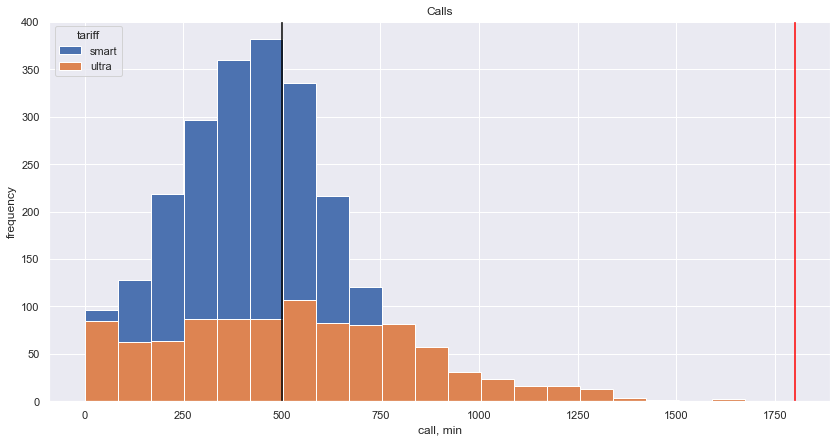

In [56]:
draw_hist(df, 'calls_sum', 20, 'call, min', 'frequency', 500, 1800, 'Calls')

Как видно из графика, можно сказать что:
- чаще всего клиентам тарифа `smart` хватает 500 минут, при ограничении в те самые 500 минут,
- чаще всего клиентам тарифа `ultra` хватает порядка 600 минут, мало кто из клиентов тратит больше 1500 минут в месяц, при ограничении в 3000 минут (стоит отметить, что на графике сделано ограничение 1800 минут, т.к. максимальное время затраченное на разговор было порядка 1600 минут)

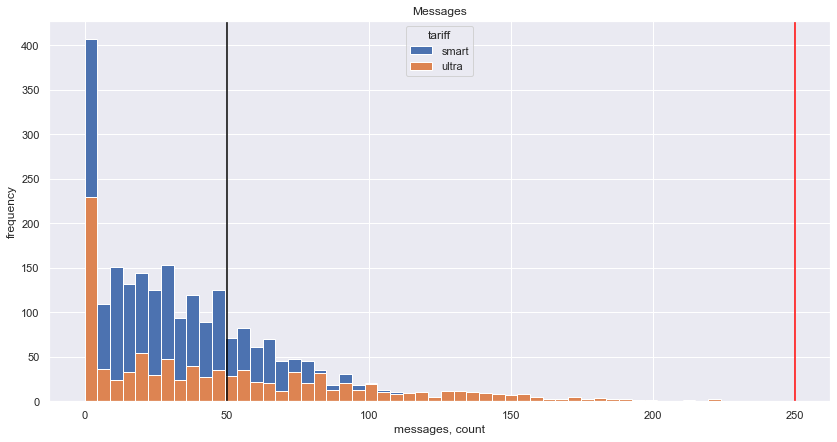

In [57]:
draw_hist(df, 'messages_count', 50, 'messages, count', 'frequency', 50, 250, 'Messages')

In [58]:
df.query('(tariff == "smart") and (messages_count <= 5)')['messages_count'].count()

430

In [59]:
df.query('(tariff == "ultra") and (messages_count <= 5)')['messages_count'].count()

240

По сообщением тоже можно заметить, что:
- тариф `smart` в большинстве отправляет порядка до 5 сообщений, при ограничиении тарифа 50 
- тариф `ultra` отправляет также большинство сообщение порядка до 5 сообщений, при ограничении 1000 (искуственно занизили до 250, т.к. после 224 уже нет значений)

Конечно, зачем СМС, когда давно есть мессенджеры. Вот в 2007 году 1000 СМС было бы хорошо, но его не вернуть, как и icq c 6 знаками.

Стоит так же отметить, что в целом на тарифе `smart` пользователи чаще отправляют СМС, чем на `ultra`, это может быть связано с тем, что нет ограничения по времени разговора, и проще всего обсудить в диалоге что-то, чем отправлять СМС.

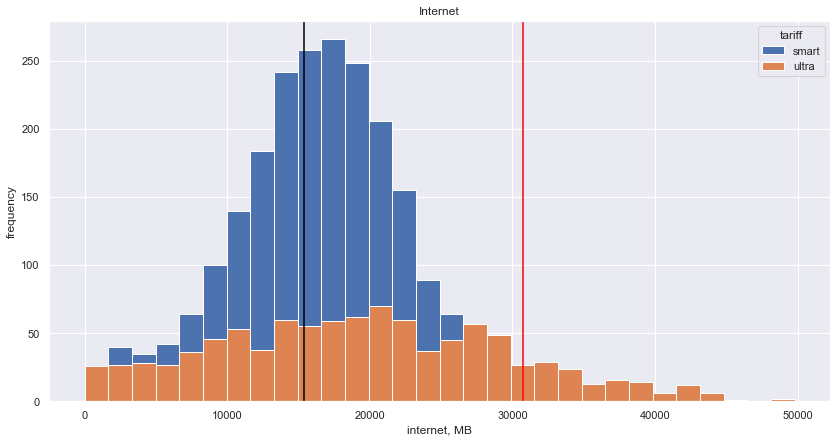

In [60]:
draw_hist(df, 'mb_used_rounded', 30, 'internet, MB', 'frequency', 15360, 30720, 'Internet')

По объему трафика можно сказать, что:
- тарифу `smart` требуется в основном порядка 17 Гб в месяц, с учетом лимита 15  Гб
- с тарифом `ultra` немного сложнее, т.к. нет явных пиков, в основном это поряка 20-30 Гб, хотя есть и те, кто тратят свыше 40 Гб, напомню, лимит - 30 Гб в месяц.

### Среднее значение, дисперсия и стандартное отклонение

Найдем среднее значение, дисперсию и стандартное отклонение для тарифов `smart и ultra`

In [61]:
(df
 .pivot_table(index='tariff', values=['calls_sum', 'messages_count', 'gb_used'], aggfunc=['mean', 'var', 'std'])
 .astype('int')
)

mean                              var                         \
       calls_sum gb_used messages_count calls_sum gb_used messages_count   
tariff                                                                     
smart        417      16             33     36219      33            796   
ultra        526      19             49    100873      97           2285   

             std                         
       calls_sum gb_used messages_count  
tariff                                   
smart        190       5             28  
ultra        317       9             47

Можно сделать вывод, что в среднем распределение трат в `ultra` сильнее разбросано вокруг среднего, больше дисперсия значений.  

Подсчитаем так же общую выручку от каждого из тарифов

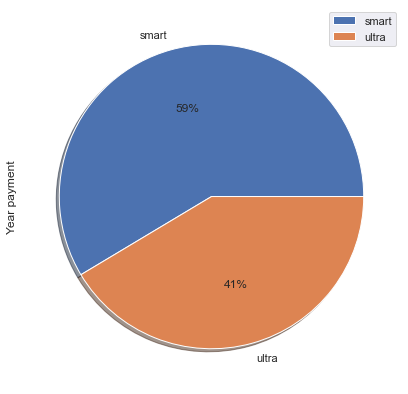

In [62]:
all_payment = df.pivot_table(index = 'tariff', values = 'month_payment', aggfunc='sum')
all_payment.columns = ['Year payment']
all_payment.plot(kind = 'pie', subplots=True, autopct='%1.0f%%', shadow=True, figsize = (14,7))
plt.show()

### Выводы

В целом, можно сказать, что пользователи тарифа `smart` более консервативные и в основном интересуются звонками и интернетом в пределах тарифа (хотя интеренета с 15 ГБ им все-таки не хватает), когда как пользователи тарифа `ultra` не ограничивают себя в траффике интернета и звонках.

## 4. Проверка гипотезы

Сформулируем Н0 и Н1 гипотезы для нашего исследования.

Гипотеза Н0 формулируется с учетом того, что средние значения в двух выборках будут равны, а гипотеза для Н1 - что различаются. 

Учитывая это, запишем:
1. Гипотеза
```
Н0: Средняя выручка пользователей тарифов «Ультра» и «Смарт» не различаются
Н1: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.
```
2. Гипотеза
```
Н0: Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов,
Н1: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
```



### Выручка пользователей тарифов «Ультра» и «Смарт»

Запишем отдельно в smart и ultra выручку с пользователей данных тарифов.

In [63]:
smart = df.loc[df['tariff'] == 'smart', 'month_payment']
ultra = df.loc[df['tariff'] == 'ultra', 'month_payment']

Найдем дисперсии для проверки их на равенство

In [64]:
equal_variance(smart)

673931.3213632498

In [65]:
equal_variance(ultra)

143491.2405596106

In [66]:
if equal_variance(smart) == equal_variance(ultra):
    print("Дисперсии равны")
else:
    print("Дисперсии НЕ равны")

Дисперсии НЕ равны


Получается, что дисперсии данных выборок НЕ равны.

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, воспользуемся тестом Стьюдента, т.к. он решает задачу доказательства наличия различий средних значений количественной переменной в случае, когда имеется лишь две сравниваемые группы.

Выполняя анализ, учтем также, что дисперсии **НЕ равны**, а значит параметр **equal_var** должен принимать значение **False**.

In [67]:
check_hip(smart, ultra, 0.05, False)

p-значение: 2.7240946993530856e-246
Отвергаем нулевую гипотезу


### Выручка пользователей из Москвы и регионов

Аналогичные рассждения применим и для анализа выручки пользователей из Москвы и остальных регионов

In [68]:
moscow_region = df.loc[df['city'] == 'Москва', 'month_payment']

In [69]:
other_region = df.loc[df['city'] != 'Москва', 'month_payment']

In [70]:
if equal_variance(moscow_region) == equal_variance(other_region):
    print("Дисперсии равны")
else:
    print("Дисперсии НЕ равны")

Дисперсии НЕ равны


In [71]:
check_hip(moscow_region, other_region, 0.05, False)

p-значение: 0.5126564657748214
Не получилось отвергнуть нулевую гипотезу


### Выводы

В ходе проверки гипотез получается, что в первом случае мы отвергаем нулевую гипотезу (логично, ведь выручка у нас от тарифов разная), а во втором - не получилось отвергнуть нулевую гипотезу.

## 5. Общий вывод

В результате исследования мы выяснили, что пользователи тарифа `smart` более консервативные и в основном интересуются звонками и интернетом в пределах тарифа (хотя интеренета с 15 ГБ им все-таки не хватает), когда как пользователи тарифа `ultra` не ограничивают себя в траффике интернета и звонках.

Можно сказать что, клиентам тарифа `smart` хватает 500 минут, при ограничении в те самые 500 минут, а клиентам тарифа `ultra` хватает порядка 600 минут, мало кто из клиентов тратит больше 1500 минут в месяц, при ограничении в 3000 минут (стоит отметить, что максимальное время затраченное на разговор было порядка 1600 минут).

По сообщением тоже можно заметить, что тариф `smart` в большинстве отправляет порядка до 5 сообщений, при ограничиении тарифа 50, а тариф `ultra` отправляет также большинство сообщений до 5, при ограничении 1000.

Стоит так же отметить, что в целом на тарифе `smart` пользователи чаще отправляют СМС, чем на `ultra`, это может быть связано с тем, что нет ограничения по времени разговора, и проще всего обсудить в диалоге что-то, чем отправлять СМС.

По объему трафика можно сказать, что тарифу `smart` требуется в основном порядка 17 Гб в месяц, с учетом лимита 15  Гб, а с тарифом `ultra` немного сложнее, т.к. нет явных пиков, в основном это поряка 20-30 Гб, хотя есть и те, кто тратят свыше 40 Гб, напомню, лимит - 30 Гб в месяц.

В ходе проверки гипотез, вспомним их:
1. Гипотеза
```
Н0: Средняя выручка пользователей тарифов «Ультра» и «Смарт» не различаются
Н1: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.
```
2. Гипотеза
```
Н0: Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов,
Н1: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
```

в первом случае мы отвергаем нулевую гипотезу (логично, ведь выручка у нас от тарифов разная), а во втором - не получилось отвергнуть нулевую гипотезу.

В заключение можно сказать, что оператору "Мегалайн" выгоднее продвигать тариф "Смарт", т.к. выручка по нему составляет 59% от всей выручки оператора.